In [1]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool
import pandas as pd
import statsmodels as sm

df = pd.read_csv("HOUST.csv")
python_repl_tool = PythonAstREPLTool(locals={"df": df})

In [2]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
import functools

system_prompt = """You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
                It is important to understand the attributes of the dataframe before working with it. This is the result of running `df.head().to_markdown()`

                <df>
                {dhead}
                </df>

                You are not meant to use only these rows to answer questions - they are meant as a way of telling you about the shape and schema of the dataframe. 
                You also do not have use only the information here to answer questions - you can run intermediate queries to do exporatory data analysis to give you more information as needed. """
system_prompt = system_prompt.format(dhead=df.head().to_markdown())

# part of the problem might be that I'm passing a PromptTemplate object for the system_prompt here
# not everything needs to be an openai tools agent
def create_agent(llm: ChatOpenAI, tools: list, task: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ), # using a global system_prompt
            HumanMessage(content=task),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

# AIMessage will have all kinds of metadata, so treat it all as HumanMessage I suppose?
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

# I need to write the mssage to state here? or is that handled automatically?
def chain_node(state, chain, name):
    result = chain.invoke(input={"detail": "low"})
    return {"messages": [HumanMessage(content=result.content, name=name)]}

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

eda_task = "Determine if the data is stationary by running an augmented dickey fuller test."
eda_agent = create_agent(llm, [python_repl_tool], task=eda_task,)
eda_node = functools.partial(agent_node, agent=eda_agent, name="EDA")

In [4]:
acf_task =  """Using the data in the dataframe `df` and the package statsmodels.
            First generate an ACF plot, display it and save it to 'acf.png'.
            Then generate a PACF plot, display it and save it to 'pacf.png'"""

# ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
acf_agent = create_agent(llm, [python_repl_tool], task=acf_task,)
acf_node = functools.partial(agent_node, agent=acf_agent, name="ACF")

In [5]:
acf_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content='This plot contains the autocorrelation function from a time series, based on the plot what AR and MA terms should be considered when modeling this time series?'),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "acf.png"}},]),
    ]
)

acf_chain = acf_template | llm
acfa_node = functools.partial(chain_node, chain=acf_chain, name="ACFanalysis")

In [6]:
from langgraph.graph import END, StateGraph, START
import operator
from typing import Sequence, TypedDict

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# add a chain to the node to analyze the ACF plot?
workflow = StateGraph(AgentState)
workflow.add_node("EDA", eda_node)
workflow.add_node("ACF", acf_node)
workflow.add_node("ACFA", acfa_node)

workflow.add_edge(START, "EDA")
workflow.add_edge("EDA", "ACF")
workflow.add_edge("ACF", "ACFA")
workflow.add_edge("ACFA", END)

graph = workflow.compile()

<Figure size 1000x500 with 0 Axes>

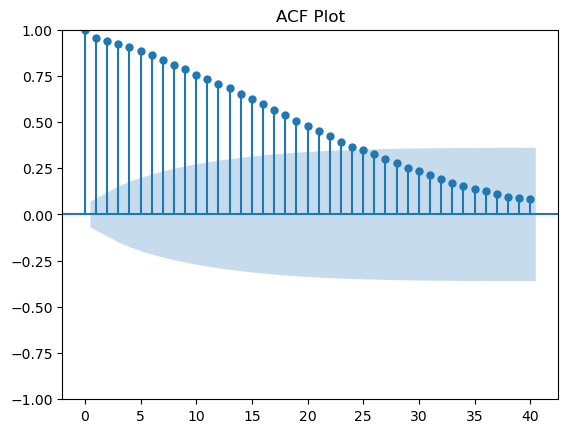

<Figure size 1000x500 with 0 Axes>

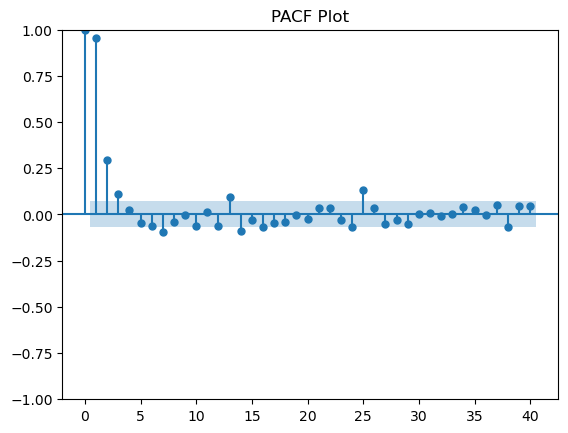

{'messages': [HumanMessage(content='Run the analysis'),
  HumanMessage(content='The results of the Augmented Dickey-Fuller test are as follows:\n\n- Test Statistic: -3.7981\n- p-value: 0.0029\n- Number of Lags: 15\n- Number of Observations: 761\n- Critical Values:\n  - 1%: -3.4390\n  - 5%: -2.8653\n  - 10%: -2.5688\n\n### Interpretation:\n- The null hypothesis of the Augmented Dickey-Fuller test is that the time series has a unit root, meaning it is non-stationary.\n- Since the p-value (0.0029) is less than the common significance levels (0.01, 0.05, and 0.10), we reject the null hypothesis.\n- Additionally, the test statistic (-3.7981) is less than the critical value at the 1% level (-3.4390), which further supports the conclusion.\n\n### Conclusion:\nThe data appears to be stationary.', name='EDA'),
  HumanMessage(content="The ACF and PACF plots have been generated, displayed, and saved as 'acf.png' and 'pacf.png', respectively. If you need to view the plots or have any further analy

In [7]:
graph.invoke({"messages": [HumanMessage(content="Run the analysis")]})

In [8]:
sys.exit()

NameError: name 'sys' is not defined

In [ ]:
# can I send both ACF and PACF plots at the same time?
# {"type": "image_url", "image_url": {"url": url}} for url in image_urls

from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langchain_core.output_parsers import StrOutputParser

chat_prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content='This plot contains the autocorrelation function from a time series, based on the plot what AR and MA terms should be considered when modeling this time series?'),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "acf.png"}},]),
    ]
)

detail = 'low'

# llm = ChatOpenAI(model_name="gpt-4o")
# output_parser = StrOutputParser()
chain = chat_prompt_template | llm
result = chain.invoke(input={"detail": detail})

print(result.content)

Based on the autocorrelation function (ACF) plot you provided, we can make some observations regarding the appropriate AR (AutoRegressive) and MA (Moving Average) terms for modeling the time series:

1. **ACF Behavior**: The ACF shows a gradual decline, which suggests that the time series may have a long memory or persistence. This behavior is indicative of an AR process.

2. **AR Terms**: Since the ACF is slowly decaying, it suggests that you might want to include one or more AR terms in your model. The number of AR terms can be determined by how long the ACF remains significantly above zero.

3. **MA Terms**: The ACF does not show a rapid cutoff, which typically indicates that MA terms may not be necessary. If the ACF were to drop to zero after a few lags, it would suggest including MA terms.

### Conclusion:
- **Consider AR terms**: Likely 1 or more, depending on how long the ACF remains significant.
- **Consider MA terms**: Likely 0, as the ACF does not show a rapid decay.

You may